In this notebook, we will show you how to load and interact with the provided checkpoints via HuggingFace.
Let first install our dependencies.

# Load models


Each of our model variants are uploaded to a HuggingFace's repository, and each folder in a repository will contain a correpsonding checkpoint.

`iter_` refers to the iteration number on which models have been saved. We provide 3 model variants (500m, 1B and 3B), and 27 checkpoints for each architecture is provided for the competition.


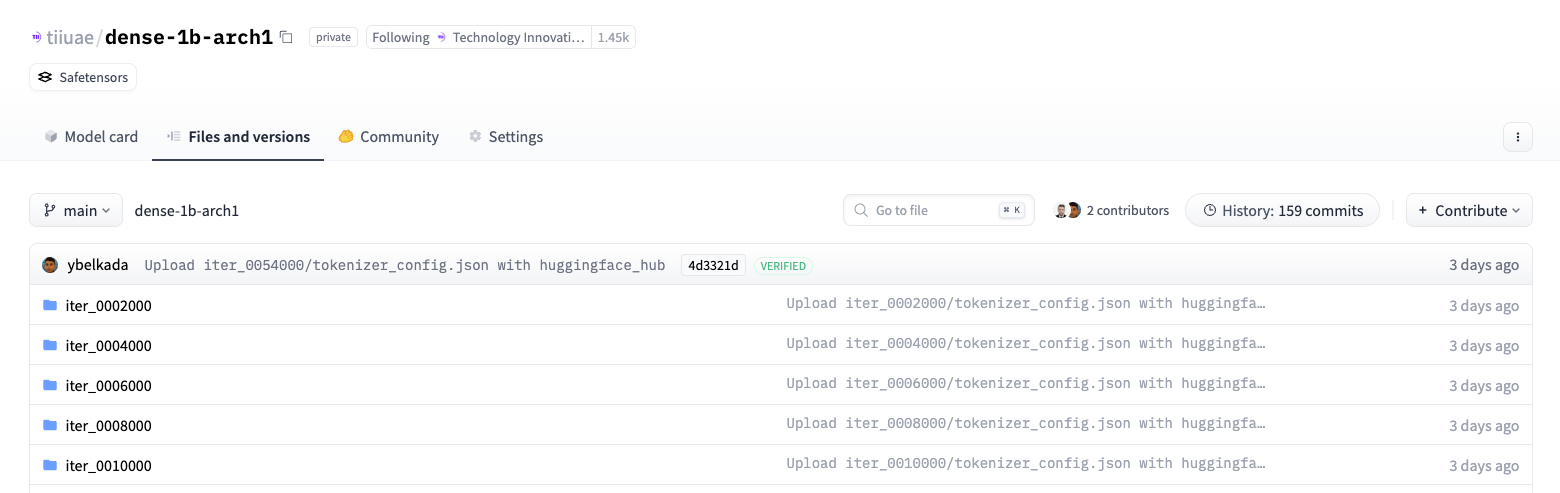

To see all the models and their checkpoints, please visit the competition's HuggingFace's collection here: https://huggingface.co/collections/tiiuae/early-training-evaluation-of-language-models-6853ef6aaaf501890f2ab363

In [2]:
# TEMPORARY for private checkpoints
import huggingface_hub
huggingface_hub.login('token')

First let import HF's `transformers`. We are going to need a tokenizer and a causal language model that support text generation.
Luckily, HF's `AutoModelForCausalLM` and `AutoTokenizer` can automatically find and initialize the correct architecture defined in the `config.json` in our repo.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

Since each of our repository has multiple subfolders checkpoints, we need to specify that as well so HF know which particular checkpoint to load:

In [4]:
repo = "knowledge-reasoning-evals/dense-1b-arch1-fix-bad"
checkpoint_folder = "iter_0002000"

model = AutoModelForCausalLM.from_pretrained(
    repo,  # which model
    subfolder=checkpoint_folder,  # which checkpoint
    torch_dtype=torch.bfloat16,  # Lower precision params to reduce memory
    device_map="auto"  # Use GPU devices if available
)

OSError: knowledge-reasoning-evals/dense-1b-arch1-fix-bad is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

We can inspec that our model is based on the Llama architectures, with approximately 1 billion parameters.

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(65536, 1280)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1280, out_features=1280, bias=False)
          (k_proj): Linear(in_features=1280, out_features=256, bias=False)
          (v_proj): Linear(in_features=1280, out_features=256, bias=False)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1280, out_features=6144, bias=False)
          (up_proj): Linear(in_features=1280, out_features=6144, bias=False)
          (down_proj): Linear(in_features=6144, out_features=1280, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1280,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((1280,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((1280,), eps=1e-06)
    (rotary_emb): 

In [ ]:
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Total number of parameters: 1,048,659,200


# Prompting and Generation

To prompt the model for generation, we are going to need the tokenizer, which convert the input text to the corresponding sequences of indices for the embedding vectors of the embedding layer.
We similarly use the same repository's name and subfolder as above to create the tokenizer:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(repo,subfolder=checkpoint_folder)

tokenizer_config.json:   0%|          | 0.00/99.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/7.42k [00:00<?, ?B/s]

In [ ]:
# Prepare your prompt
prompt = "As of 2013, which of the following countries had the highest per capita rate of homelessness? A. US  B. Chile  C. Ireland  D.Spain"

# Tokenize the input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

NameError: name 'tokenizer' is not defined

In [ ]:
inputs

{'input_ids': tensor([[ 1243,  3458,   817,   784, 21659,  3958,   813, 11090,   535,   784,
         29920,   823, 36464,   860]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The output of the tokenizer is a dictionary, which contains the `input_ids` Tensor as the sequence of tokens. By default, the tokenizer will automatically add a batch dimension.
Since we have only 1 sample, we can access the token indices for our prompt at the index `0`:

In [ ]:
print(f"Text prompt with {len(prompt)} characters was converted to `input_ids` with {len(inputs.input_ids[0])} tokens.")

Text prompt with 75 characters was converted to `input_ids` with 14 tokens.


We can also decode back the encoded indices for sanity check that it's working as intended.

In [ ]:
tokenizer.decode(inputs["input_ids"][0])

'The answer to the ultimate question of Life, the Universe and Everything is'

Now let try to generate the completion for our prompt using the method `generate()` that comes with our `AutoModelForCausalLM` class.

In [ ]:
# Generate text
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
    )
# Decode the output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generation: ", generated_text)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation:  The answer to the ultimate question of Life, the Universe and Everything is that the universe is the only thing that exists.
The universe is the only thing that exists.


Aside from the `input_ids` and optional `attention_mask` from the tokenizer, we can also control other generation's hyperparameters to adjust the generation quality:

In [ ]:
# Generate text
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_length=200,  # Adjust based on your needs
        temperature=0.7,  # Controls randomness: lower → more deterministic
        top_p=0.9,  # Nucleus sampling: consider tokens with top_p probability mass
        do_sample=True,  # Use sampling instead of greedy decoding
        repetition_penalty=1.2  # Penalize repetition
    )

# Decode the output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generation: ", generated_text)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation:  The answer to the ultimate question of Life, the Universe and Everything is:
"How shall we know that God exists?"
It was a statement in response to the fact that one can't tell if God exists. It's true that there are many other examples out there where this would not be so; but these are usually just explanations or some kind of theory on how you got here without knowing what happened at all about which universe it is. (Some of those questions have been covered elsewhere.) The only way to prove the existence of God is by using the example of a person who is in a plane with no consciousness and knows nothing whatsoever from their own experiences. This does not mean that they cannot experience anything from any of them. But it means that they have to explain why something like this happens when they go into another dimension or another planet for example.
For instance, I could try to explain the effect of an atomic explosion on the galaxy when my wife did her hair


We see, adjusting these generation hyperparameters sometime can make a huge differences in the model's responses.

# Going further

In this notebook we have seen how to load any of the provided model checkpoints and prompt them for generation.
In the next notebook, we will see how to load and evaluate a model checkpoint on a standard benchmark.